In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
train_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
submission_csv = pd.read_csv('/kaggle/input/home-data-for-ml-course/sample_submission.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [5]:
print(train_data.head(5))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [6]:
print(train_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
non_numerical = train_data.select_dtypes(exclude=['int', 'float']).columns
print(non_numerical)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [8]:
# Your 1D array
array = np.array(non_numerical)

# Reshape to 2D array with shape (n_samples, 1)
array_reshaped = array.reshape(-1, 1)

print(array_reshaped)

[['MSZoning']
 ['Street']
 ['Alley']
 ['LotShape']
 ['LandContour']
 ['Utilities']
 ['LotConfig']
 ['LandSlope']
 ['Neighborhood']
 ['Condition1']
 ['Condition2']
 ['BldgType']
 ['HouseStyle']
 ['RoofStyle']
 ['RoofMatl']
 ['Exterior1st']
 ['Exterior2nd']
 ['MasVnrType']
 ['ExterQual']
 ['ExterCond']
 ['Foundation']
 ['BsmtQual']
 ['BsmtCond']
 ['BsmtExposure']
 ['BsmtFinType1']
 ['BsmtFinType2']
 ['Heating']
 ['HeatingQC']
 ['CentralAir']
 ['Electrical']
 ['KitchenQual']
 ['Functional']
 ['FireplaceQu']
 ['GarageType']
 ['GarageFinish']
 ['GarageQual']
 ['GarageCond']
 ['PavedDrive']
 ['PoolQC']
 ['Fence']
 ['MiscFeature']
 ['SaleType']
 ['SaleCondition']]


In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
encoder = OneHotEncoder()
encoder.fit(array_reshaped)

OneHotEncoder()

In [11]:
encoded_data = encoder.transform(array_reshaped).toarray()

In [12]:
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out
                          (['feature_name']))
print(df_encoded.head(5))

   feature_name_Alley  feature_name_BldgType  feature_name_BsmtCond  \
0                 0.0                    0.0                    0.0   
1                 0.0                    0.0                    0.0   
2                 1.0                    0.0                    0.0   
3                 0.0                    0.0                    0.0   
4                 0.0                    0.0                    0.0   

   feature_name_BsmtExposure  feature_name_BsmtFinType1  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   feature_name_BsmtFinType2  feature_name_BsmtQual  feature_name_CentralAir  \
0                        0.0                    0.0                      0.0   
1                        0.0                    0.0       

In [13]:
# Remove the prefix 'feature_name_' from the column names
df_encoded.columns = df_encoded.columns.str.replace('feature_name_', '')

# Display the updated DataFrame
print(df_encoded.head())

   Alley  BldgType  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2  \
0    0.0       0.0       0.0           0.0           0.0           0.0   
1    0.0       0.0       0.0           0.0           0.0           0.0   
2    1.0       0.0       0.0           0.0           0.0           0.0   
3    0.0       0.0       0.0           0.0           0.0           0.0   
4    0.0       0.0       0.0           0.0           0.0           0.0   

   BsmtQual  CentralAir  Condition1  Condition2  ...  MiscFeature  \
0       0.0         0.0         0.0         0.0  ...          0.0   
1       0.0         0.0         0.0         0.0  ...          0.0   
2       0.0         0.0         0.0         0.0  ...          0.0   
3       0.0         0.0         0.0         0.0  ...          0.0   
4       0.0         0.0         0.0         0.0  ...          0.0   

   Neighborhood  PavedDrive  PoolQC  RoofMatl  RoofStyle  SaleCondition  \
0           0.0         0.0     0.0       0.0        0.0         

In [14]:
print(df_encoded.isna().sum())
# no missing value from the df_encoded

Alley            0
BldgType         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
BsmtQual         0
CentralAir       0
Condition1       0
Condition2       0
Electrical       0
ExterCond        0
ExterQual        0
Exterior1st      0
Exterior2nd      0
Fence            0
FireplaceQu      0
Foundation       0
Functional       0
GarageCond       0
GarageFinish     0
GarageQual       0
GarageType       0
Heating          0
HeatingQC        0
HouseStyle       0
KitchenQual      0
LandContour      0
LandSlope        0
LotConfig        0
LotShape         0
MSZoning         0
MasVnrType       0
MiscFeature      0
Neighborhood     0
PavedDrive       0
PoolQC           0
RoofMatl         0
RoofStyle        0
SaleCondition    0
SaleType         0
Street           0
Utilities        0
dtype: int64


In [15]:
print(df_encoded.duplicated().sum())
#no duplication

0


In [16]:
# Extract numerical columns from train_data
numericals = train_data.select_dtypes(include=['int', 'float']).columns
numerical_columns = train_data[numericals]
print(numerical_columns.head(5))

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  WoodDeckSF  OpenPorchSF  \
0          2003       196.0         706  ...           0           61   
1          1976         0.0         978  ...         298            0   
2          2002       162.0         486  ...           0           42   
3          1970         0.0         216  ...           0           35   
4          2000       350.0         655  ...         192           84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  \
0

In [17]:
print(numerical_columns.isna().sum())

Id                 0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64


In [18]:
numerical_columns = numerical_columns.fillna(0)
print(numerical_columns.isna().sum())

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64


In [19]:
# Concatenate numerical_columns and df_encoded
result = pd.concat([numerical_columns, df_encoded], axis=1)
print(result.head(5))

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  MiscFeature  Neighborhood  \
0          2003       196.0         706  ...          0.0           0.0   
1          1976         0.0         978  ...          0.0           0.0   
2          2002       162.0         486  ...          0.0           0.0   
3          1970         0.0         216  ...          0.0           0.0   
4          2000       350.0         655  ...          0.0           0.0   

   PavedDrive  PoolQC  RoofMatl  RoofStyle  SaleCondition  SaleType 

In [20]:
result = result.replace([np.inf, -np.inf], np.nan).fillna(0)  # Replace inf with NaN and then fill NaN with 0
print(result)


        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  MiscFeature  \
0          2003          2003       

In [21]:
# Check for any remaining invalid values
if result.isnull().any().any() or np.isinf(result.select_dtypes(include=[np.number])).any().any():
    print("Warning: There are still missing or infinite values in the DataFrame.")

print(result.head())

   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  MiscFeature  Neighborhood  \
0          2003       196.0         706  ...          0.0           0.0   
1          1976         0.0         978  ...          0.0           0.0   
2          2002       162.0         486  ...          0.0           0.0   
3          1970         0.0         216  ...          0.0           0.0   
4          2000       350.0         655  ...          0.0           0.0   

   PavedDrive  PoolQC  RoofMatl  RoofStyle  SaleCondition  SaleType 

In [22]:
print(result.isna().sum())

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
                ..
RoofStyle        0
SaleCondition    0
SaleType         0
Street           0
Utilities        0
Length: 81, dtype: int64


In [23]:
correlation_matrix = result.corr()

In [24]:
high_corr_values = correlation_matrix.loc[correlation_matrix['SalePrice'] >= 0.3, 'SalePrice']
print(high_corr_values)

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [25]:
X = result.drop('SalePrice', axis = 1)
y = result['SalePrice']

In [26]:
print(X)

        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  MiscFeature  \
0          2003          2003       

In [27]:
print(y)

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


In [28]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [30]:
pca = PCA()  # By default, PCA keeps all components
X_pca = pca.fit_transform(X_scaled)

Explained Variance Ratio: [8.59115231e-02 4.02570609e-02 2.78596348e-02 2.62749010e-02
 2.02209056e-02 1.71901334e-02 1.68707005e-02 1.64892897e-02
 1.63150946e-02 1.59475991e-02 1.53706344e-02 1.49210584e-02
 1.46949618e-02 1.42177109e-02 1.38444432e-02 1.35229391e-02
 1.34665694e-02 1.31175579e-02 1.30378879e-02 1.30002778e-02
 1.28670839e-02 1.27323870e-02 1.27175656e-02 1.26322991e-02
 1.26229894e-02 1.25867570e-02 1.25617016e-02 1.25519519e-02
 1.25386648e-02 1.25336505e-02 1.25224356e-02 1.25186624e-02
 1.25159685e-02 1.25125143e-02 1.25085675e-02 1.25085675e-02
 1.25085675e-02 1.25085675e-02 1.25085675e-02 1.25085675e-02
 1.25085675e-02 1.25085675e-02 1.25085675e-02 1.25085252e-02
 1.24383890e-02 1.23228846e-02 1.22406282e-02 1.21308683e-02
 1.20788954e-02 1.19682261e-02 1.18091543e-02 1.15392497e-02
 1.14510038e-02 1.12265833e-02 1.09830742e-02 1.07735429e-02
 1.04484929e-02 9.98993208e-03 9.72808483e-03 9.45214211e-03
 9.10456827e-03 8.92198818e-03 8.81919007e-03 8.28651649e-0

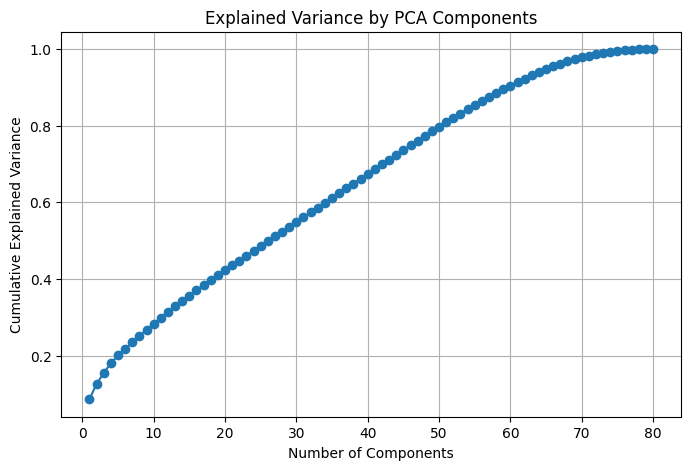

In [31]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [32]:
# Retain components that explain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components to retain: {n_components}")

# Re-run PCA with the selected number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

Number of components to retain: 66


In [33]:
# Example: Split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
# Initialize and train the model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [36]:
# Make predictions
y_pred = model.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

In [38]:
# Evaluate the model
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 1972851080.6164384
R^2 Score: 0.7427943704965416


In [39]:
# View coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: [-1.04934430e+00 -1.87164080e+00 -2.87287479e+00 -1.58884348e+00
 -1.27159432e+00 -1.66867718e+00 -1.14126052e+00 -1.28088285e+00
 -1.74661233e+00 -3.04374914e-01 -1.91240658e+00 -1.67043312e-01
 -4.10472217e-01 -5.95555504e-01 -5.90926494e-01 -1.66457642e+00
  3.83432611e-01 -1.22389224e+00 -2.00866833e+00 -1.47555283e+00
 -1.16569966e+00  8.77297799e-01  3.63324538e-02 -5.48243855e-01
 -9.13904340e-01 -4.45114066e-01 -1.09473935e+00 -5.18323175e-01
 -1.93452346e+00 -1.43192504e+00 -2.47940261e-01 -8.75390545e-01
  1.67249993e-01 -1.73447407e+00 -8.19002011e-01 -8.95830429e-01
 -3.18728439e-01 -2.24788599e-01  1.21478103e-01 -8.46490105e-01
  9.81520368e-02 -1.55348084e+00 -4.83241184e-01  3.02626819e-01
 -2.94087350e-01 -1.76144647e-01  6.81188239e-01  1.18536637e-01
 -4.06041853e-01  2.11841650e-01 -8.93567146e-02  2.52047247e-01
 -1.35185672e+00  1.25289265e+00 -6.47494924e-01  3.90413158e-01
 -5.79752018e-01  7.27528264e-01  3.68190954e-01  4.56739187e-01
  2.20072361e-

In [40]:
print("Model Parameters:", model.get_params())

Model Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [41]:
X_test = pd.DataFrame(X_test)

In [42]:
# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,'SalePrice': y_pred})
output.to_csv('sample_submission.csv', index=False)
